# Predicting farm reciepts(revenue) from expenses using a Random Forest Regressor


In [1]:
# %pip install pandas numpy scikit-learn joblib openpyxl matplotlib seaborn notebook 


In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer

# helper functions
def _is_year(v):
    if isinstance(v, (int, float)) and not pd.isna(v):
        return 1900 <= int(v) <= 2100
    if isinstance(v, str):
        return bool(re.match(r"\d{4}", v))
    return False

def _find_year_row(df):
    for r in range(min(15, df.shape[0])):
        if sum(_is_year(x) for x in df.iloc[r, 1:15]) >= 3:
            return r
    raise ValueError("Year header row not found")

def _parse_years(row):
    yrs = []
    for v in row:
        if _is_year(v):
            yrs.append(int(re.match(r"(\d{4})", str(v)).group(1)) if isinstance(v, str) else int(v))
    return yrs

def parse_bea_sheet(df):
    yr_idx = _find_year_row(df)
    years = _parse_years(df.iloc[yr_idx, 1:].values)
    cols = [j for j in range(1, df.shape[1]) if _is_year(df.iloc[yr_idx, j])]
    start = yr_idx + 2
    data = {}
    for i in range(start, df.shape[0]):
        cat = df.iloc[i, 0]
        if isinstance(cat, str) and cat.strip() and not cat.lower().startswith("footnote"):
            vals = []
            for j in cols[:len(years)]:
                v = df.iloc[i, j]
                if isinstance(v, (int, float)):
                    vals.append(float(v))
                elif isinstance(v, str):
                    s = v.replace(",", "").replace("$", "").replace(" ", "").replace(" ", "")
                    try:
                        vals.append(float(s))
                    except ValueError:
                        vals.append(np.nan)
                else:
                    vals.append(np.nan)
            if not all(pd.isna(vals)):
                data[cat.strip().lower()] = vals
    return pd.DataFrame(data, index=years)


## Loading and cleansing of data

In [3]:
# Paths
INCOME_STATEMENT_FILE_PATH = "IncomeDataLarge_raw.xlsx"
EXPENSE_STATEMENT_FILE_PATH = "PE_State_US_raw.xlsx"

# load both files data
income_data_df = parse_bea_sheet(pd.read_excel(INCOME_STATEMENT_FILE_PATH, sheet_name="United States", header=None)).sort_index()
expenses_data_df = parse_bea_sheet(pd.read_excel(EXPENSE_STATEMENT_FILE_PATH, sheet_name="United States", header=None)).sort_index()

# use the features derived from EDA
expense_cols = [
    "seed",
    "fertilizer, lime, and soil conditioner",
    "fuel and oils",
    "electricity",
    "hired labor",
    "pesticide",
    "machine hire and custom work",
    "marketing, storage, and transportation",
    "nonreal estate interest",
]

expense_cols = [c for c in expense_cols if c in expenses_data_df.columns]
data = pd.concat([income_data_df["all commodity receipts"], expenses_data_df[expense_cols]], axis=1)
print(data.shape) # (116, 10)

imp = SimpleImputer(strategy="mean")
data = pd.DataFrame(imp.fit_transform(data), columns=data.columns, index=data.index)

y = data["all commodity receipts"]
X = data[expense_cols]

data *= 1_000 # scale the data to real world value as raw data was divided by 1000
data


(116, 10)


,all commodity receipts,seed,"fertilizer, lime, and soil conditioner",fuel and oils,electricity,hired labor,pesticide,machine hire and custom work,"marketing, storage, and transportation",nonreal estate interest
1910,5.780000e+09,5.600000e+07,1.520000e+08,1.100000e+07,1.000000e+06,1.493284e+10,7.000000e+06,2.681122e+09,4.455130e+09,2.070000e+08
1911,5.584000e+09,6.500000e+07,1.680000e+08,1.400000e+07,1.000000e+06,1.493284e+10,7.000000e+06,2.681122e+09,4.455130e+09,2.120000e+08
1912,6.008000e+09,7.400000e+07,1.610000e+08,1.800000e+07,1.000000e+06,1.493284e+10,7.000000e+06,2.681122e+09,4.455130e+09,2.210000e+08
1913,6.238000e+09,6.200000e+07,1.750000e+08,2.200000e+07,1.000000e+06,1.493284e+10,7.000000e+06,2.681122e+09,4.455130e+09,2.410000e+08
1914,6.036000e+09,6.200000e+07,1.950000e+08,2.300000e+07,2.000000e+06,1.493284e+10,7.000000e+06,2.681122e+09,4.455130e+09,2.440000e+08
...,...,...,...,...,...,...,...,...,...,...
2021,4.424170e+11,2.231548e+10,2.954387e+10,1.392664e+10,6.383375e+09,3.000118e+10,1.781824e+10,4.864037e+09,1.047667e+10,6.269609e+09
2022,5.426107e+11,2.502442e+10,3.663431e+10,1.848537e+10,6.412774e+09,3.515630e+10,2.141721e+10,5.382525e+09,1.118523e+10,7.980779e+09
2023,5.169458e+11,2.732666e+10,3.583356e+10,1.760598e+10,7.072529e+09,4.120184e+10,2.161737e+10,6.317601e+09,1.265894e+10,1.045955e+10
2024,5.168025e+11,2.660855e+10,3.288380e+10,1.548482e+10,7.484196e+09,4.393771e+10,1.929632e+10,6.159893e+09,1.348506e+10,1.102333e+10


# **Exploratory Data Analysis**

## Summary Statistics + Time Series Plot of Receipts and Expenses

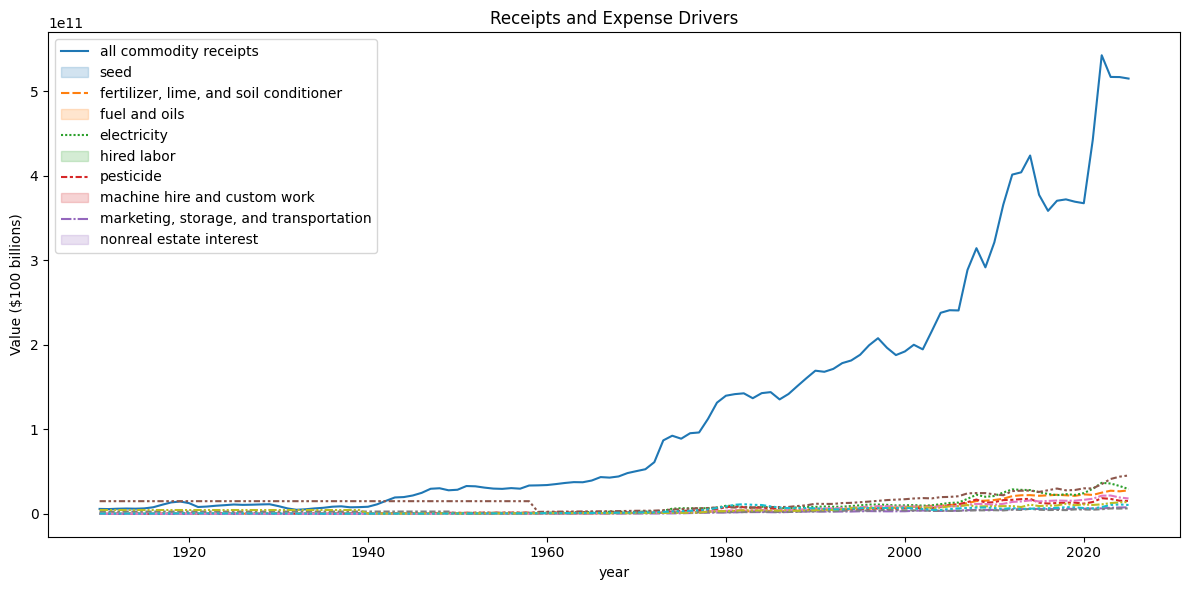

In [4]:
data.describe()
plt.figure(figsize=(12,6))
sns.lineplot(data=data)
plt.title('Receipts and Expense Drivers')
plt.xlabel('year')
plt.ylabel('Value ($100 billions)')
plt.legend(data.columns, loc='upper left')
plt.tight_layout()
plt.show()

## Correlation Heatmap (matrix)

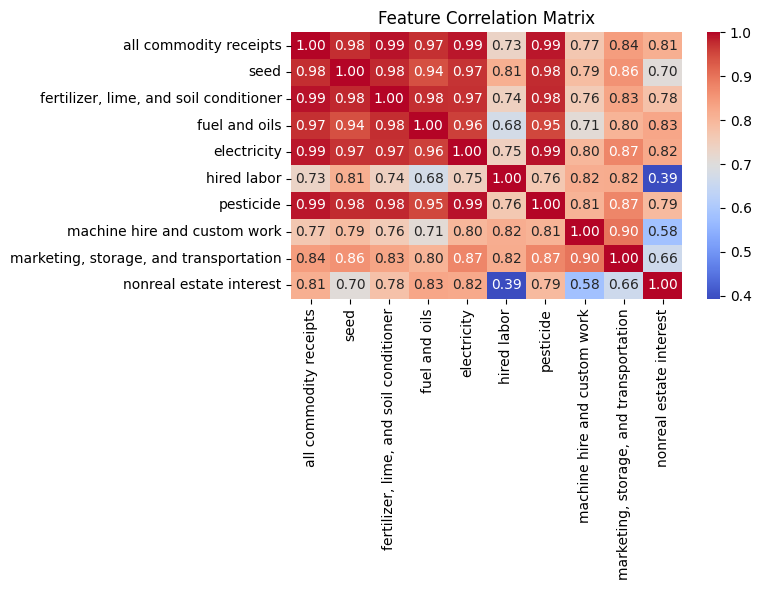

In [5]:
plt.figure(figsize=(8,6))
corr = data.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## Pairplot

c:\Users\Risha\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


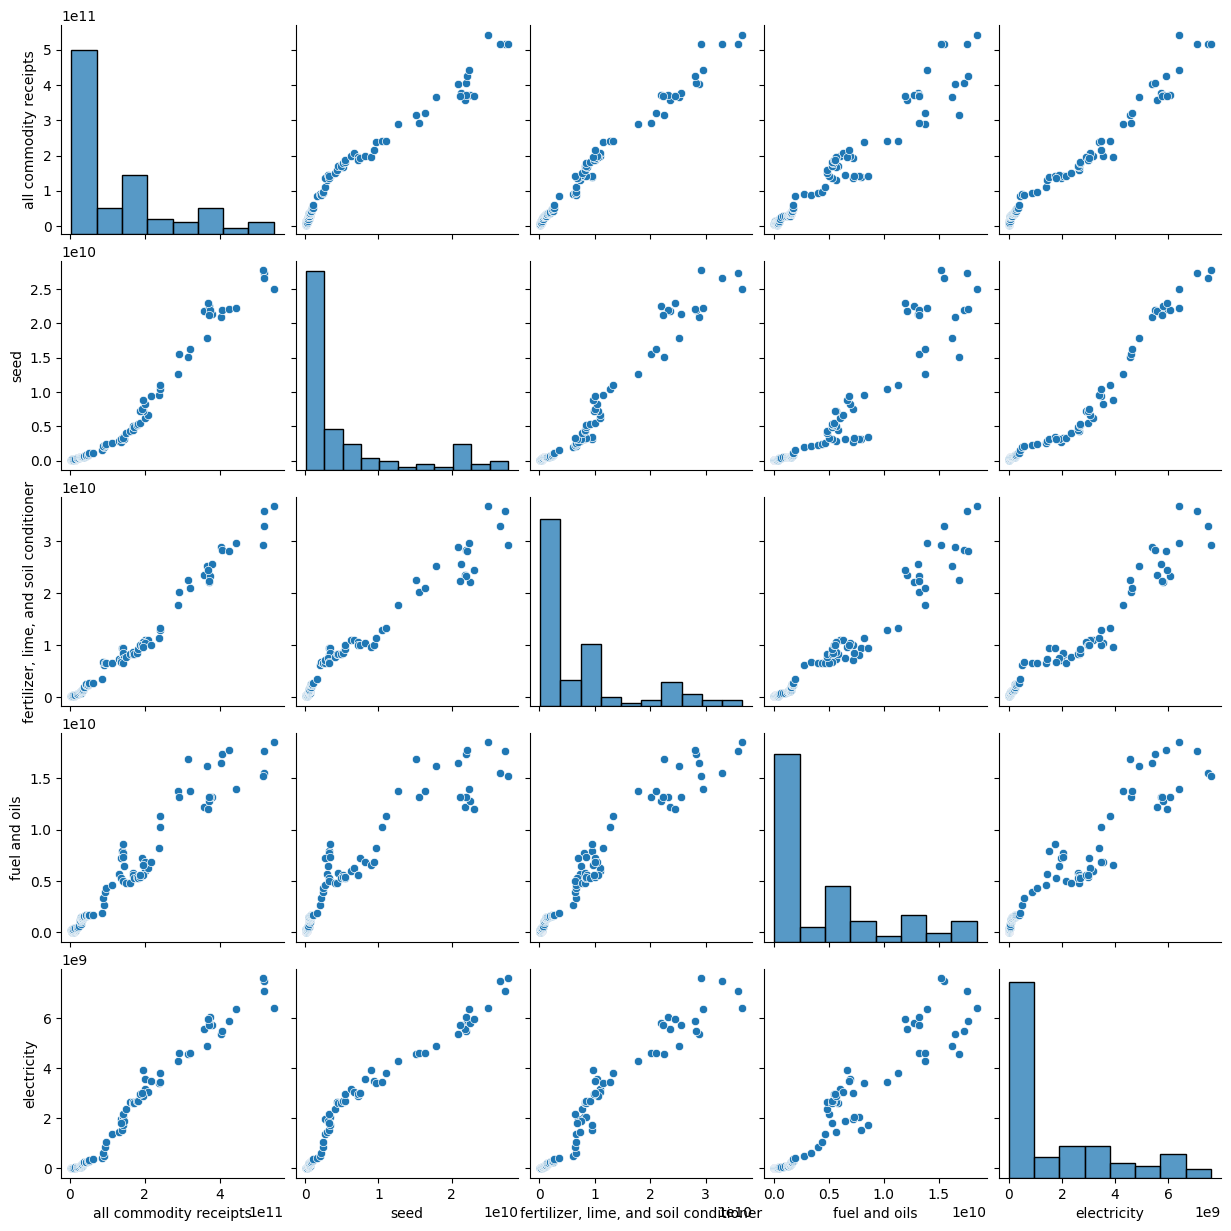

In [6]:
sns.pairplot(data.iloc[:, :5])  # only the first 5 columns for readability
plt.show()

## Simple linear regression of electricity and all commodity receipts

coefficient: 64.9350, intercept: 15496215873.9626, R^2: 0.9794


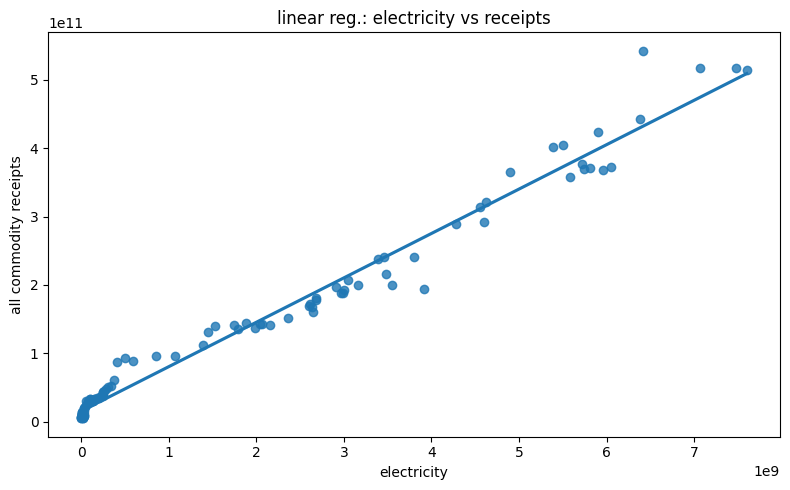

In [7]:
# prepare variables
X_electricity = data[['electricity']].values
y_all_commodity_reciepts = data['all commodity receipts'].values

# fit the simple linear regression model
simple_linear_reg = LinearRegression()
simple_linear_reg.fit(X_electricity, y_all_commodity_reciepts)
y_pred = simple_linear_reg.predict(X_electricity)
print(f'coefficient: {simple_linear_reg.coef_[0]:.4f}, intercept: {simple_linear_reg.intercept_:.4f}, R^2: {r2_score(y_all_commodity_reciepts, y_pred):.4f}')

# plot the regression of electricity vs reciepts
plt.figure(figsize=(8,5))
sns.regplot(x='electricity', y='all commodity receipts', data=data, ci=None)
plt.title('linear reg.: electricity vs receipts')
plt.tight_layout()
plt.show()

## Multivariable linear regression

intercept: 18556460907.9093
seed: -1978.8235
fertilizer, lime, and soil conditioner: 8043.8482
fuel and oils: -308.6251
electricity: 29290.8904
hired labor: 249.4164
pesticide: 4511.4059
machine hire and custom work: -2428.0881
marketing, storage, and transportation: -1883.1337
nonreal estate interest: 465.3271
R^2: 0.9962


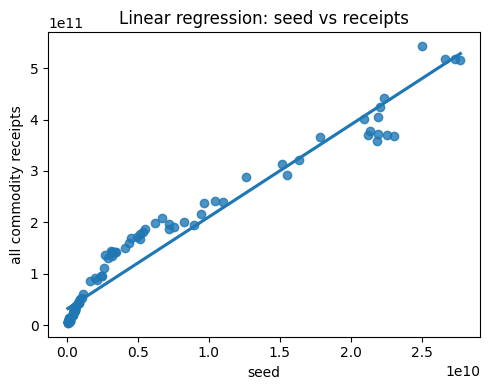

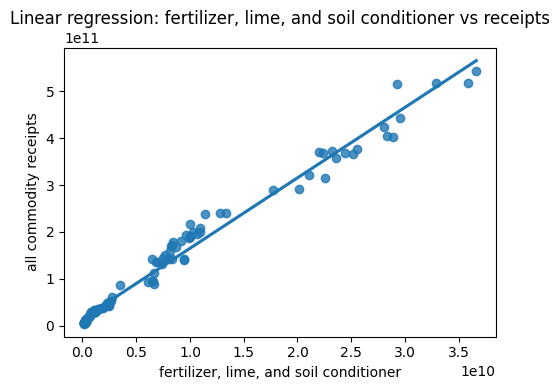

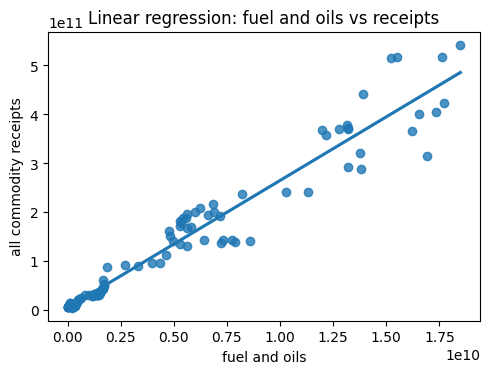

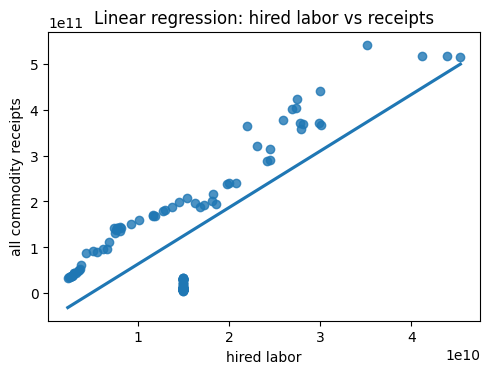

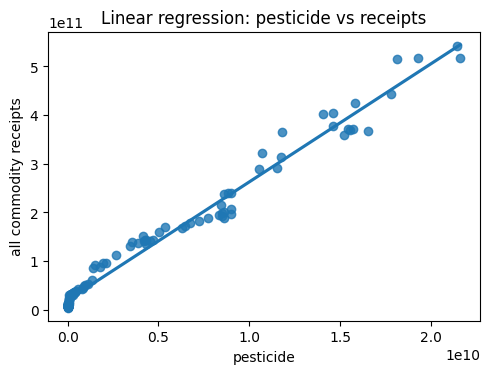

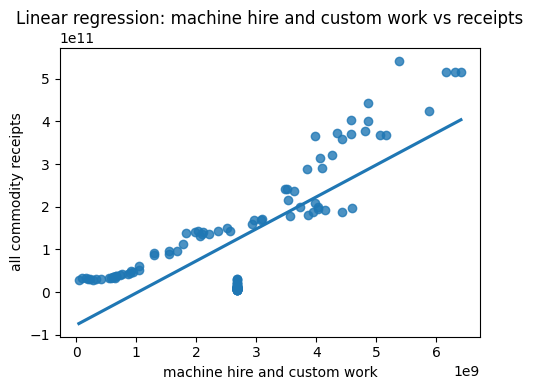

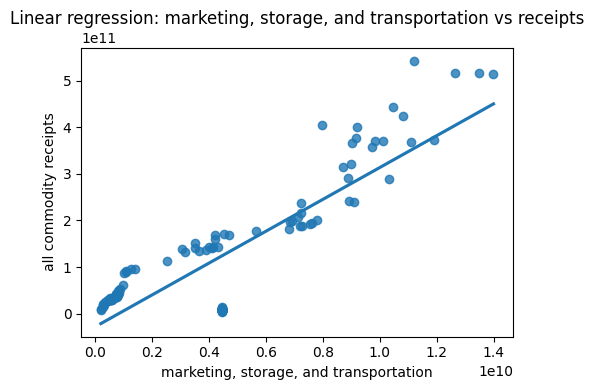

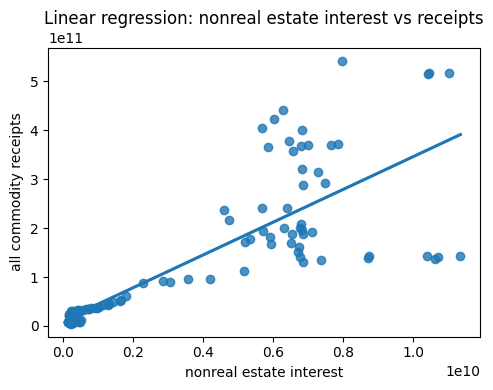

In [ ]:
# multi variable linear regression on all expense features
multivar_linear_reg_all = LinearRegression()
multivar_linear_reg_all.fit(X, y_all_commodity_reciepts)

y_all_pred = multivar_linear_reg_all.predict(X)
print(f'intercept: {multivar_linear_reg_all.intercept_:.4f}')
for feat, coef in zip(expense_cols, multivar_linear_reg_all.coef_):
    print(f'{feat}: {coef:.4f}')
print(f'R^2: {r2_score(y_all_commodity_reciepts, y_all_pred):.4f}')

# graph each of 
for exp in expense_cols:
    if exp == "electricity":
        continue
    plt.figure(figsize=(5, 4))
    sns.regplot(x=exp, y='all commodity receipts', data=data, ci=None)
    plt.title(f'Linear regression: {exp} vs receipts')
    plt.tight_layout()
    plt.show()


# **Random Forest Supervised Learning**

## 5 fold cross validation

In [9]:

random_forest_model = RandomForestRegressor(n_estimators=500, random_state=0)
cross_val = KFold(n_splits=5, shuffle=True, random_state=0)
cross_val_r2 = cross_val_score(random_forest_model, X, y, cv=cross_val, scoring="r2")
print("5-fold cross_val R² scores:", np.round(cross_val_r2,5))
print("Mean cross_val R²:", cross_val_r2.mean())

'''
5-fold CV R² scores: [0.9868  0.99552 0.99016 0.98186 0.97024]
Mean CV R²: 0.9849168846162062
'''

# Fit full model
random_forest_model.fit(X, y)


5-fold cross_val R² scores: [0.99593 0.98889 0.99857 0.99398 0.98405]
Mean cross_val R²: 0.9922858293335262


RandomForestRegressor(n_estimators=500, random_state=0)

## Time series split

In [14]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_val_predict

# 5 folds, each split uses everything up to that point for training
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(random_forest_model, X, y,
                            cv=tscv, scoring="r2", n_jobs=-1)
print("Time-series CV R^2 scores:", np.round(cv_scores, 4))
print("Mean CV R^2            :", cv_scores.mean())

'''
Time-series CV R² scores: [ 0.0145 -1.8368 -3.447  -4.5261 -4.8663]
Mean CV R²            : -2.9323235171125317
'''



Time-series CV R^2 scores: [ 0.0145 -1.8368 -3.447  -4.5261 -4.8663]
Mean CV R^2            : -2.9323235171125317


'\nTime-series CV R² scores: [ 0.0145 -1.8368 -3.447  -4.5261 -4.8663]\nMean CV R²            : -2.9323235171125317\n'

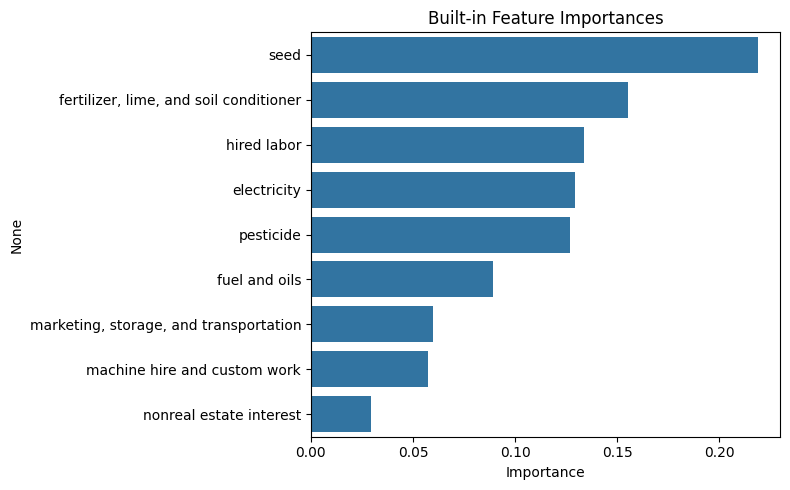

In [11]:
# feature importance plot 
importances = pd.Series(random_forest_model.feature_importances_, index=expense_cols).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Built-in Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


## **Permutation importances:** 
### done to measure the importance of each feature by seeing how much the model's performance degrades when that feature's values are randomly shuffled 

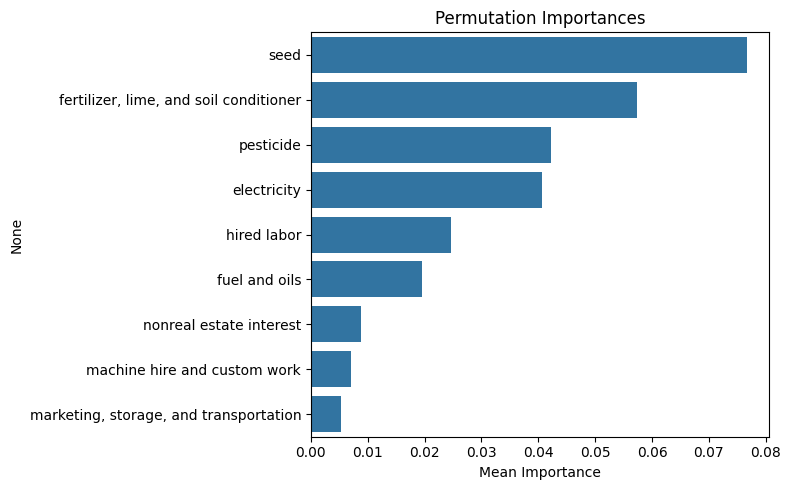

'\nMean Importance       Std\nseed                                           0.067648  0.006371\nfertilizer, lime, and soil conditioner         0.052705  0.004277\nhired labor                                    0.045946  0.004772\npesticide                                      0.031523  0.002725\nelectricity                                    0.030644  0.002615\nfuel and oils                                  0.014145  0.001229\nmarketing, storage, and transportation         0.011763  0.001179\nmachine hire and custom work                   0.008575  0.000879\nnonreal estate interest                        0.003616  0.000396\n'

In [12]:

perm = permutation_importance(random_forest_model, X, y, n_repeats=30, random_state=0)
perm_df = pd.DataFrame({
    'Mean Importance': perm.importances_mean,
    'Std': perm.importances_std
}, index=expense_cols).sort_values('Mean Importance', ascending=False)
# print(perm_df)

plt.figure(figsize=(8,5))
sns.barplot(x='Mean Importance', y=perm_df.index, data=perm_df)
plt.title('Permutation Importances')
plt.tight_layout()
plt.show()

'''
Mean Importance       Std
seed                                           0.067648  0.006371
fertilizer, lime, and soil conditioner         0.052705  0.004277
hired labor                                    0.045946  0.004772
pesticide                                      0.031523  0.002725
electricity                                    0.030644  0.002615
fuel and oils                                  0.014145  0.001229
marketing, storage, and transportation         0.011763  0.001179
machine hire and custom work                   0.008575  0.000879
nonreal estate interest                        0.003616  0.000396
'''

## **Out Of Fold prediction (OOF-prediction) -** 
### Predict each data point using a model that never saw that point during training

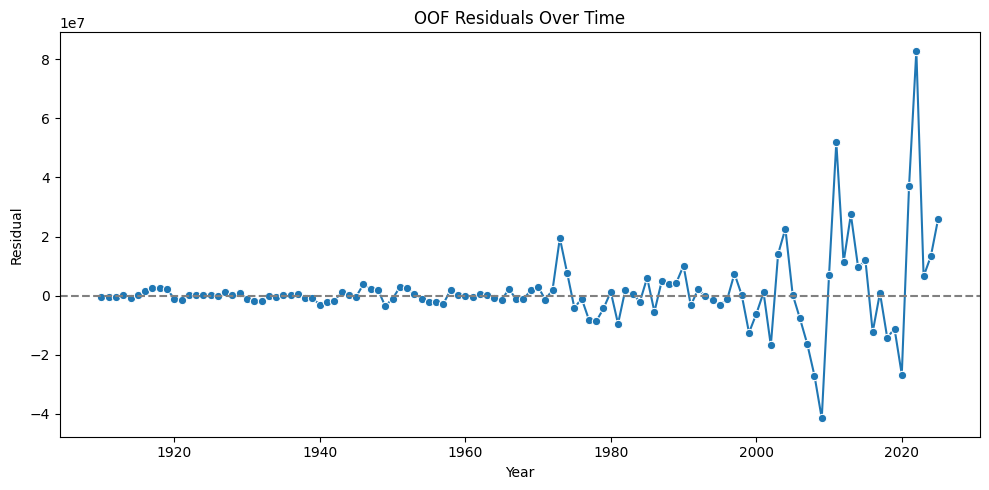

In [13]:
oof_pred = cross_val_predict(random_forest_model, X, y, cv=cross_val)
res_oof = y - oof_pred
res_df = pd.DataFrame({'Year': data.index, 'Residual': res_oof})

plt.figure(figsize=(10,5))
sns.lineplot(x='Year', y='Residual', data=res_df, marker='o')
plt.axhline(0, linestyle='--', color='gray')
plt.title('OOF Residuals Over Time')
plt.tight_layout()
plt.show()
